In [2]:
import convolution.kernel
import convolution.matrix
from noise import guassian_noise

from signals import rectangle, mix, smooth
from domain import equispaced_points


import matplotlib.pyplot as plt

from scipy.sparse import spdiags


import numpy as np

In [3]:
def data(N, sigma, noise_percentage, signal):
    t = equispaced_points(N)
    latent_signal = signal(t)
    k1_true = convolution.kernel.Gaussian(
    domain=t, 
    standard_deviation=sigma
)
    K_true = convolution.matrix.Operator(
    kernel=k1_true, 
    structure=convolution.matrix.toeplitz
)
    convoluted_signal = K_true.image @ latent_signal
    percentage = noise_percentage
    noise = guassian_noise(percentage, convoluted_signal)
    return convoluted_signal + noise



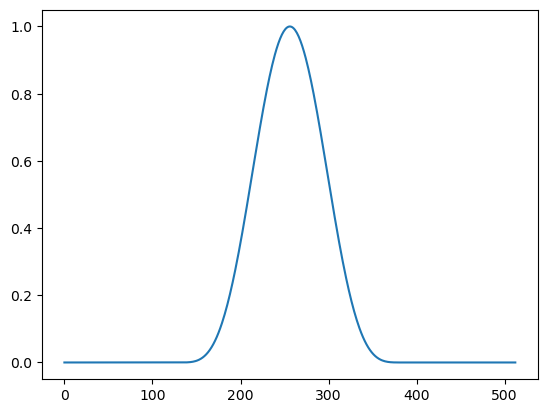

In [4]:
N = 512
t = equispaced_points(N)
latent_signal = smooth(t)
d = data(N=512, sigma=30, noise_percentage=0.02, signal=mix)
plt.plot(latent_signal)

Define regulation matrices. 

The identity matrix. 

In [5]:
def I(x): 
    return np.identity(x.size)

Total variation.

In [6]:
def total_variation(x): 
    BETA = 1e-16
    D = forward_difference_matrix(x)
    return np.diag((1/(((D @ x)**2 + BETA**2)**(1/4)))) @ D

def forward_difference_matrix(data): 
    return spdiags([-np.ones_like(data), np.ones_like(data)], [0, 1], data.size, data.size).toarray()

In [7]:
from scipy.linalg import pinv

def G(sigma): 

    g = convolution.kernel.Gaussian(
        domain=t, 
        standard_deviation=sigma
    )
    G = convolution.matrix.Operator(
        kernel=g, 
        structure=convolution.matrix.toeplitz
    )
    return G.image

def reduced_functional(sigmas, reg_parameter, reg_matrix, data): 
    result = []
    L = reg_matrix(latent_signal)
    for sigma in sigmas:
        GL = np.block([[G(sigma)], [reg_parameter * L]])
        D = np.block([data, np.zeros_like(data)]) # data: d tilde (not derivative operator)
        x = pinv(GL) @ D
        result.append(
            np.linalg.norm(GL @ x - D)
        )
    return result

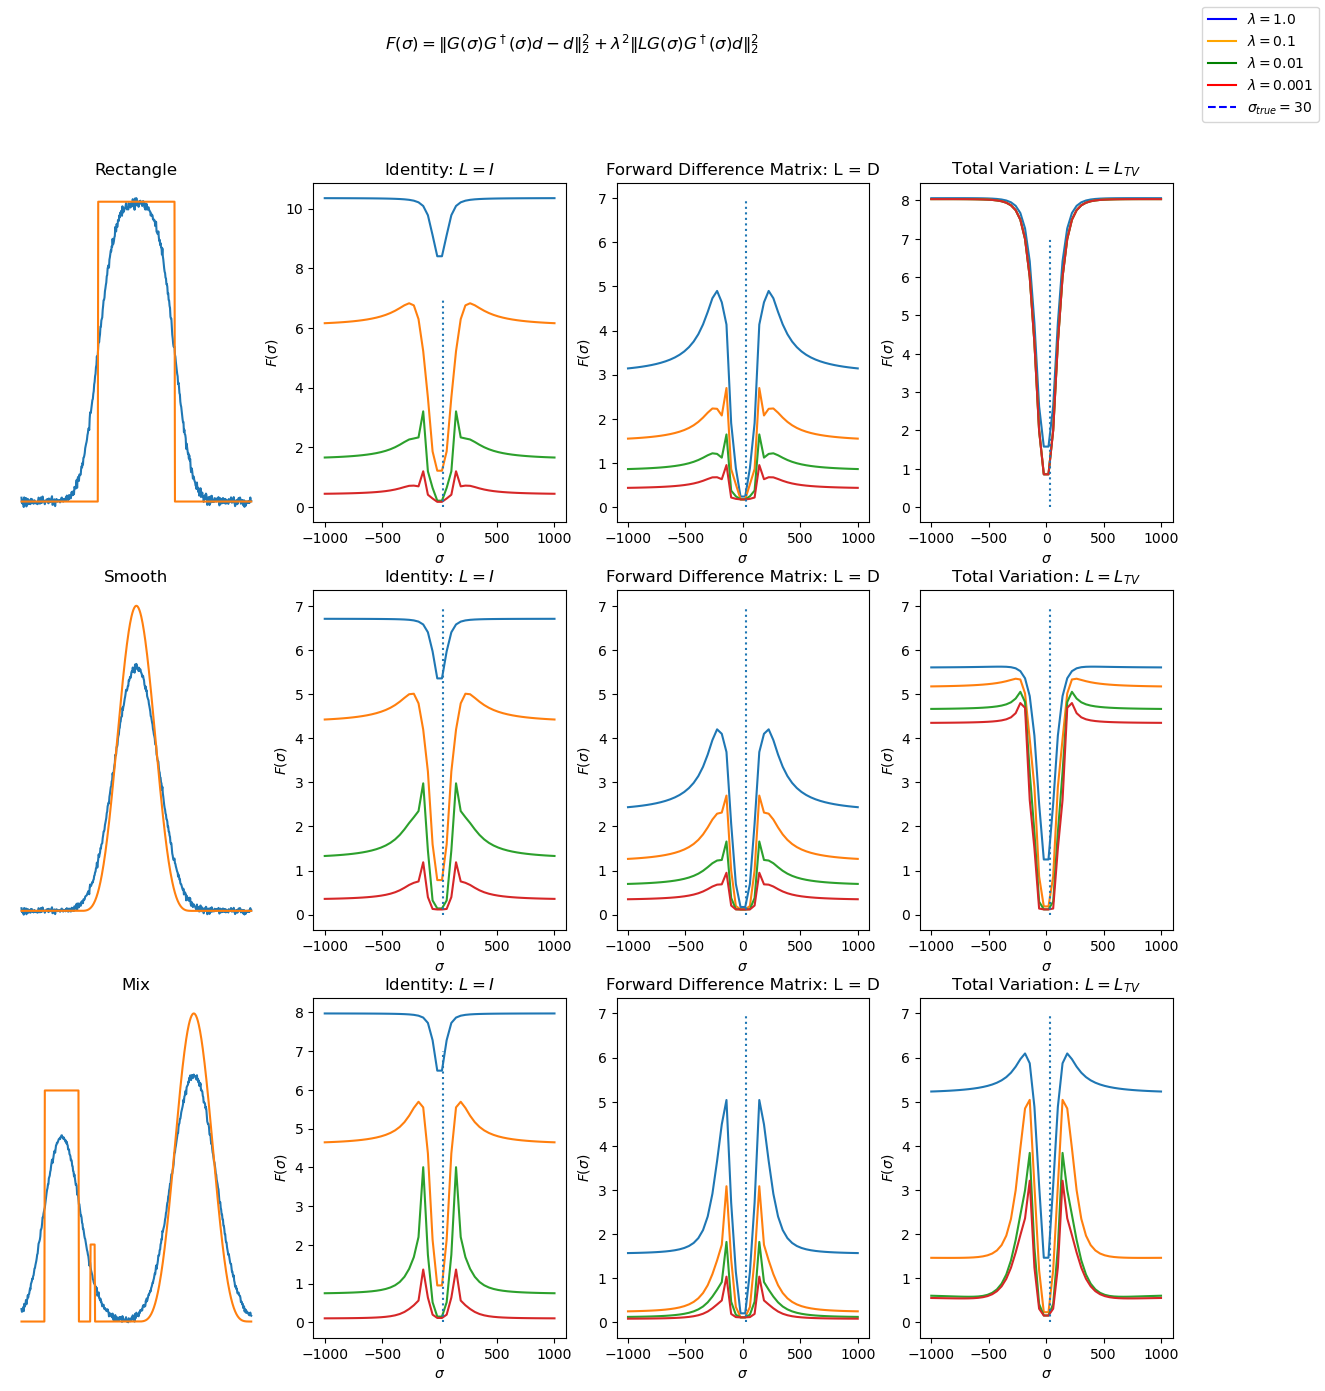

In [28]:
sigmas = np.linspace(-1000,1000)

fig, axs = plt.subplots(3, 4, figsize=(15, 15))
fig.suptitle(r'$F(\sigma) = \|G(\sigma)G^\dagger(\sigma)d - d \|_2^2 + \lambda^2 \|L G(\sigma)G^\dagger(\sigma)d\|_2^2$')

for axe, sig in zip(axs, [rectangle, smooth, mix]):
    latent_signal = sig(t)
    d =  data(N, sigma=30, noise_percentage=0.02, signal=sig)
    ax = axe[0]
    ax.plot(t, d)
    ax.plot(t, latent_signal)
    ax.axis('off')
    ax.set_title(f'{sig.__name__}'.capitalize())

    ax = axe[1]
    L = I
    for reg_parameter in [1e0, 1e-1, 1e-2, 1e-3]:
        F0 = reduced_functional(sigmas, reg_parameter, I, d)
        ax.plot(sigmas, F0)
    ax.title.set_text('Identity: ' + r'$L = I$')
    ax.vlines(30, 0, 7, linestyles=':')
    ax.set_ylabel(r'$F(\sigma)$')
    ax.set_xlabel(r'$\sigma$')

    ax = axe[2]
    for reg_parameter in [1e0, 1e-1, 1e-2, 1e-3]:
        F0 = reduced_functional(sigmas, reg_parameter, forward_difference_matrix, d)
        ax.plot(sigmas, F0)
    ax.title.set_text('Forward Difference Matrix: ' + r'L = D')
    ax.vlines(30, 0, 7, linestyles=':')
    ax.set_ylabel(r'$F(\sigma)$')

    ax.set_xlabel(r'$\sigma$')

    ax = axe[3]
    for reg_parameter in [1e0, 1e-1, 1e-2, 1e-3]:
        F0 = reduced_functional(sigmas, reg_parameter, total_variation, d)
        ax.plot(sigmas, F0)
    ax.title.set_text('Total Variation: ' + r'$L = L_{TV}$')
    ax.vlines(30, 0, 7, linestyles=':')
    ax.set_xlabel(r'$\sigma$')
    ax.set_ylabel(r'$F(\sigma)$')

from matplotlib.lines import Line2D
lines = [Line2D([0], [0], color='blue'), Line2D([0], [0], color='orange'), Line2D([0], [0], color='green'), Line2D([0], [0], color='red'),  Line2D([0], [0], color='blue', linestyle='--')  ]
labels = [r'$\lambda=$' + f'{reg_parameter}' for reg_parameter in [1e0, 1e-1, 1e-2, 1e-3]] + [r'$\sigma_{true}=$' + f'30']
fig.legend(lines,labels, loc='upper right')


Recall that the true standard deviation is 30. 

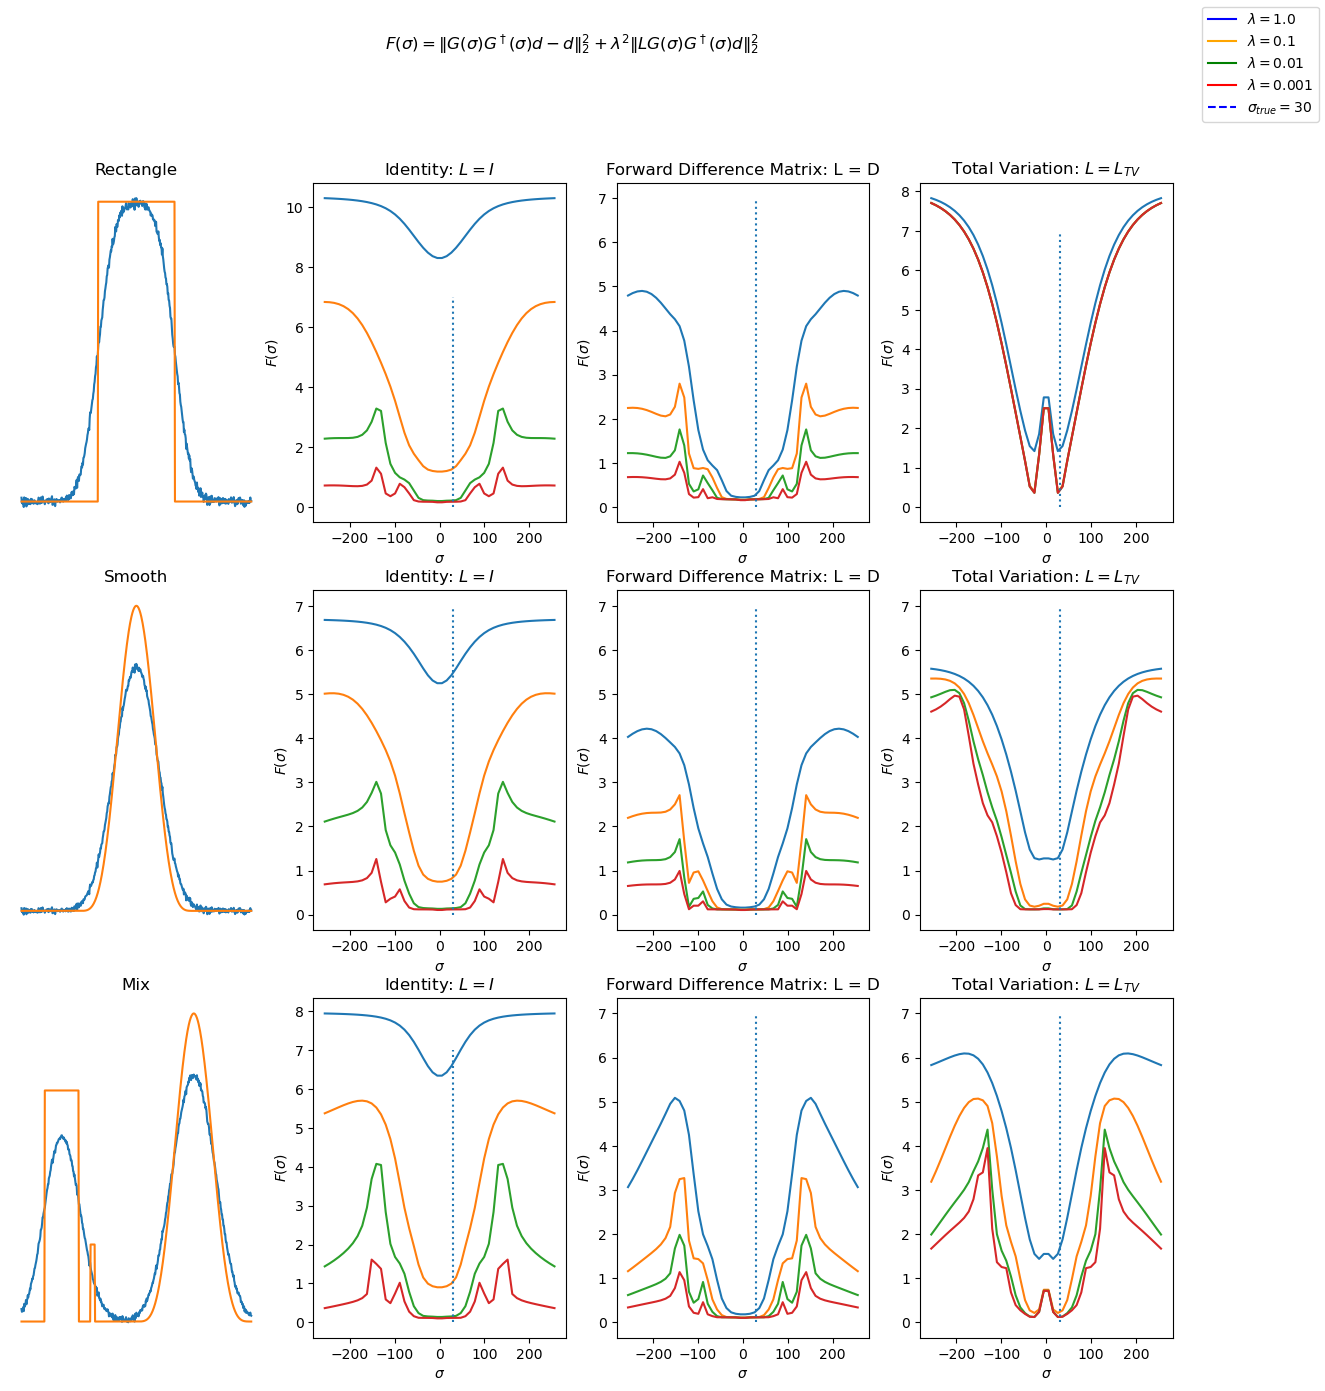

In [29]:
sigmas = np.linspace(-256,256)

fig, axs = plt.subplots(3, 4, figsize=(15, 15))
fig.suptitle(r'$F(\sigma) = \|G(\sigma)G^\dagger(\sigma)d - d \|_2^2 + \lambda^2 \|L G(\sigma)G^\dagger(\sigma)d\|_2^2$')

for axe, sig in zip(axs, [rectangle, smooth, mix]):
    latent_signal = sig(t)
    d =  data(N, sigma=30, noise_percentage=0.02, signal=sig)
    ax = axe[0]
    ax.plot(t, d)
    ax.plot(t, latent_signal)
    ax.axis('off')
    ax.set_title(f'{sig.__name__}'.capitalize())

    ax = axe[1]
    L = I
    for reg_parameter in [1e0, 1e-1, 1e-2, 1e-3]:
        F0 = reduced_functional(sigmas, reg_parameter, I, d)
        ax.plot(sigmas, F0)
    ax.title.set_text('Identity: ' + r'$L = I$')
    ax.vlines(30, 0, 7, linestyles=':')
    ax.set_ylabel(r'$F(\sigma)$')
    ax.set_xlabel(r'$\sigma$')

    ax = axe[2]
    for reg_parameter in [1e0, 1e-1, 1e-2, 1e-3]:
        F0 = reduced_functional(sigmas, reg_parameter, forward_difference_matrix, d)
        ax.plot(sigmas, F0)
    ax.title.set_text('Forward Difference Matrix: ' + r'L = D')
    ax.vlines(30, 0, 7, linestyles=':')
    ax.set_ylabel(r'$F(\sigma)$')

    ax.set_xlabel(r'$\sigma$')

    ax = axe[3]
    for reg_parameter in [1e0, 1e-1, 1e-2, 1e-3]:
        F0 = reduced_functional(sigmas, reg_parameter, total_variation, d)
        ax.plot(sigmas, F0)
    ax.title.set_text('Total Variation: ' + r'$L = L_{TV}$')
    ax.vlines(30, 0, 7, linestyles=':')
    ax.set_xlabel(r'$\sigma$')
    ax.set_ylabel(r'$F(\sigma)$')

from matplotlib.lines import Line2D
lines = [Line2D([0], [0], color='blue'), Line2D([0], [0], color='orange'), Line2D([0], [0], color='green'), Line2D([0], [0], color='red'),  Line2D([0], [0], color='blue', linestyle='--')  ]
labels = [r'$\lambda=$' + f'{reg_parameter}' for reg_parameter in [1e0, 1e-1, 1e-2, 1e-3]] + [r'$\sigma_{true}=$' + f'30']
fig.legend(lines,labels, loc='upper right')